# Análise de entrevista utilizando Whisper e Bert.


Nos últimos anos, o campo do Processamento de Linguagem Natural (PLN) tem experimentado avanços significativos, impulsionados pelo desenvolvimento de modelos de aprendizado profundo. Dentre esses modelos, o BERT (Bidirectional Encoder Representations from Transformers), proposto por Devlin et al. (2018), destaca-se por sua capacidade de capturar detalhes contextuais em textos, graças à sua arquitetura baseada em transformadores.

A análise de entrevistas é uma metodologia amplamente utilizada em pesquisas qualitativas, permitindo a coleta de dados ricos em informações sobre percepções, experiências e comportamentos humanos. No entanto, o processo de transcrição e análise manual dessas entrevistas pode ser demorado e sujeito a vieses interpretativos. Nesse contexto, a aplicação de técnicas avançadas de PLN pode otimizar esse processo, fornecendo insights mais precisos e agilizando a interpretação dos dados.

Este trabalho explora o uso da biblioteca Wisper e BERT na análise de entrevistas em língua portuguesa, visando aprimorar a extração de informações e a compreensão dos conteúdos abordados. Ao aplicar o BERT, buscamos identificar padrões semânticos e temáticos nas respostas dos entrevistados, proporcionando uma análise mais profunda e automatizada.



# Dados Coletados

Foram coletadas 40 entrevistas que seram utilizadas para validação de um aplicativo chamado DreamSteps.

# Bibliotecas

In [19]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, pipeline
from openai import OpenAI as GPT
import os
import nltk
from nltk.corpus import stopwords
from nltk import tokenize
import torch
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Conversão de dados utilizando Whisper

No processo de análise de entrevistas, a transcrição precisa e eficiente dos áudios para texto é uma etapa crucial. É aqui que entra em cena o modelo Whisper, desenvolvido pela OpenAI, que oferece uma solução poderosa para a transcrição automática de áudio em texto. Whisper é um modelo de reconhecimento de voz open-source que tem demonstrado alta precisão em diversas línguas e ambientes ruidosos, tornando-o ideal para a transcrição de entrevistas conduzidas em diferentes contextos.

Ao utilizar o Whisper, o áudio das entrevistas é convertido em texto de forma rápida e precisa. Isso não só reduz consideravelmente o tempo necessário para transcrição manual, mas também minimiza os erros humanos associados a esse processo. Whisper se destaca pela sua capacidade de entender fala contínua e variabilidades de sotaque, que são comuns em entrevistas, garantindo que o output textual represente fielmente o conteúdo falado.

Uma vez que as entrevistas são transcritas com Whisper, os textos resultantes servem como input para o modelo BERT, que irá realizar a análise semântica. Com os textos transcritos, o BERT poderá aplicar técnicas de Processamento de Linguagem Natural (PLN) para identificar temas, emoções e padrões linguísticos nas respostas dos entrevistados, enriquecendo a análise qualitativa com insights que podem não ser imediatamente aparentes em uma leitura convencional.

In [20]:
def transcribe_audio(file_path):
    transcription_file = file_path + ".txt"
    if os.path.exists(transcription_file):
        with open(transcription_file, 'r', encoding='utf-8') as f:
            return f.read()

    with open(file_path, 'rb') as audio_file:
        response = GPT().audio.transcriptions.create(model="whisper-1",language="pt",file=audio_file)
        transcription = response.text.encode().decode()

    with open(transcription_file, 'w', encoding='utf-8') as f:
        f.write(transcription)

    return transcription

Este foi o código utilizado para converter os audios em textos. Seus conteúdos foram salvos em arquivos .txt e disponibilizados.

In [21]:
def read_interviews(directory):
    interviews = []
    token_espaco = tokenize.WhitespaceTokenizer() #Ferramenta separa por espaços brancos e acentuação
    for filename in os.listdir(directory):
        print(f'Processing {filename}...')
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                interviews.append(file.read().lower())
    return interviews

# Analise com BERT

In [22]:
def analisar_entrevistas(entrevistas):
    # Carregar o tokenizer e o modelo BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Carregar a pipeline de análise de sentimentos
    sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

    resultados = []
    embeddings = []
    dados = []

    # Definindo max_length para truncamento
    max_length = 512

    for entrevista in entrevistas:
        # Tokenizar o texto da entrevista
        inputs = tokenizer(entrevista, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # Obter embeddings usando o modelo BERT
        with torch.no_grad():
            outputs = model(**inputs)

        # Extrair o embedding médio da última camada oculta
        last_hidden_state = outputs.last_hidden_state
        mean_embedding = last_hidden_state.mean(dim=1).squeeze().numpy()

        embeddings.append(mean_embedding)

         # Dividir entrevistas longas em partes gerenciáveis
        partes = [entrevista[i:i+max_length] for i in range(0, len(entrevista), max_length)]

        # Analisar cada parte separadamente
        sentimentos = []
        for parte in partes:
            resultado_sentimento = sentiment_pipeline(parte[:max_length])  # Truncar para garantir comprimento adequado
            dados.append(parte[:max_length])
            sentimento = resultado_sentimento[0]['label']
            confianca = resultado_sentimento[0]['score']
            sentimentos.append((sentimento, confianca))

        # Agregar resultados (aqui simplesmente pegamos o primeiro como exemplo; pode-se criar lógica mais complexa)
        sentimento_agregado = max(sentimentos, key=lambda x: x[1])[0]  # Usar o de maior confiança
        confianca_agregada = np.mean([c for _, c in sentimentos])     # Média da confiança como exemplo

        resultados.append({'texto': entrevista, 'sentimento': sentimento_agregado, 'confianca': round(confianca_agregada, 2)})

    # Calcular similaridades entre as entrevistas
    similarities = cosine_similarity(embeddings)

    return resultados, similarities,dados

In [23]:
resultados, similarities,dados = analisar_entrevistas(read_interviews("/content/entrevistas"))

# Exibir os resultados de sentimentos
for resultado in resultados:
    print(f"Texto: {resultado['texto']}\nSentimento: {resultado['sentimento']} (Confiança: {resultado['confianca']})\n")

# Exibir a matriz de similaridade
print("Matriz de Similaridade:")
print(similarities)

Processing entrevista 31.txt...
Processing entrevista 23.txt...
Processing entrevista 21.txt...
Processing entrevista 19.txt...
Processing entrevista 4.txt...
Processing entrevista 20.txt...
Processing entrevista 29.txt...
Processing entrevista 18.txt...
Processing entrevista 26.txt...
Processing entrevista 1.txt...
Processing entrevista 34.txt...
Processing entrevista 27.txt...
Processing entrevista 15.txt...
Processing entrevista 22.txt...
Processing entrevista 5.txt...
Processing entrevista 33.txt...
Processing entrevista 32.txt...
Processing entrevista 11.txt...
Processing entrevista 10.txt...
Processing entrevista 25.txt...
Processing entrevista 39.txt...
Processing entrevista 13.txt...
Processing entrevista 14.txt...
Processing entrevista 7.txt...
Processing entrevista 12.txt...
Processing entrevista 9.txt...
Processing entrevista 3.txt...
Processing entrevista 6.txt...
Processing entrevista 37.txt...
Processing entrevista 17.txt...
Processing entrevista 35.txt...
Processing entr

In [24]:
def visualizar_resultados(resultados):
    # Extrair dados relevantes
    sentimentos = [resultado['sentimento'] for resultado in resultados]
    confiancas = [resultado['confianca'] for resultado in resultados]

    # Contagem de sentimentos
    contagem_sentimentos = {}
    for sentimento in sentimentos:
        if sentimento in contagem_sentimentos:
            contagem_sentimentos[sentimento] += 1
        else:
            contagem_sentimentos[sentimento] = 1

    # Criar histogramas de sentimentos
    plt.figure(figsize=(10, 5))
    plt.bar(contagem_sentimentos.keys(), contagem_sentimentos.values(), color=['green', 'red', 'blue'])
    plt.xlabel('Sentimento')
    plt.ylabel('Número de Entrevistas')
    plt.title('Distribuição de Sentimentos')
    plt.show()

    # Calcular confiança média por sentimento
    confianca_media_por_sentimento = {}
    for sentimento in set(sentimentos):
        indices = [i for i, s in enumerate(sentimentos) if s == sentimento]
        confianca_media_por_sentimento[sentimento] = np.mean([confiancas[i] for i in indices])

    # Criar gráfico de barras de confiança média por sentimento
    plt.figure(figsize=(10, 5))
    plt.bar(confianca_media_por_sentimento.keys(), confianca_media_por_sentimento.values(), color=['green', 'red', 'blue'])
    plt.xlabel('Sentimento')
    plt.ylabel('Confiança Média')
    plt.title('Confiança Média por Sentimento')
    plt.show()


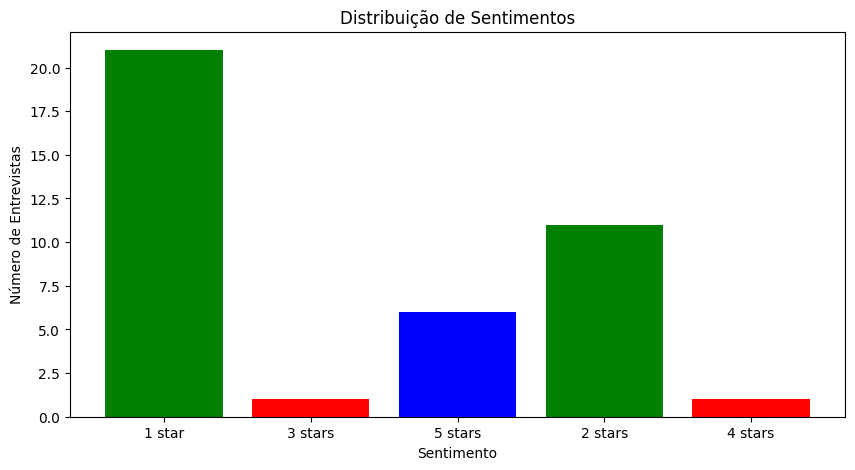

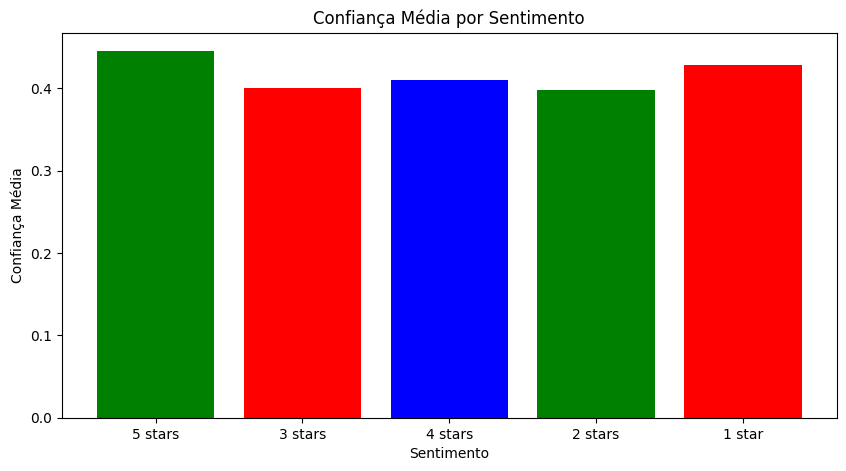

In [25]:
visualizar_resultados(resultados)

In [32]:
def visualizar_similaridades(similarities, entrevistas):
    # Criar uma matriz de calor para as similaridades
    plt.figure(figsize=(15, 15))
    sns.heatmap(similarities, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Similaridade Cosseno entre Entrevistas')
    plt.xlabel('Entrevista Index')
    plt.ylabel('Entrevista Index')
    plt.show()


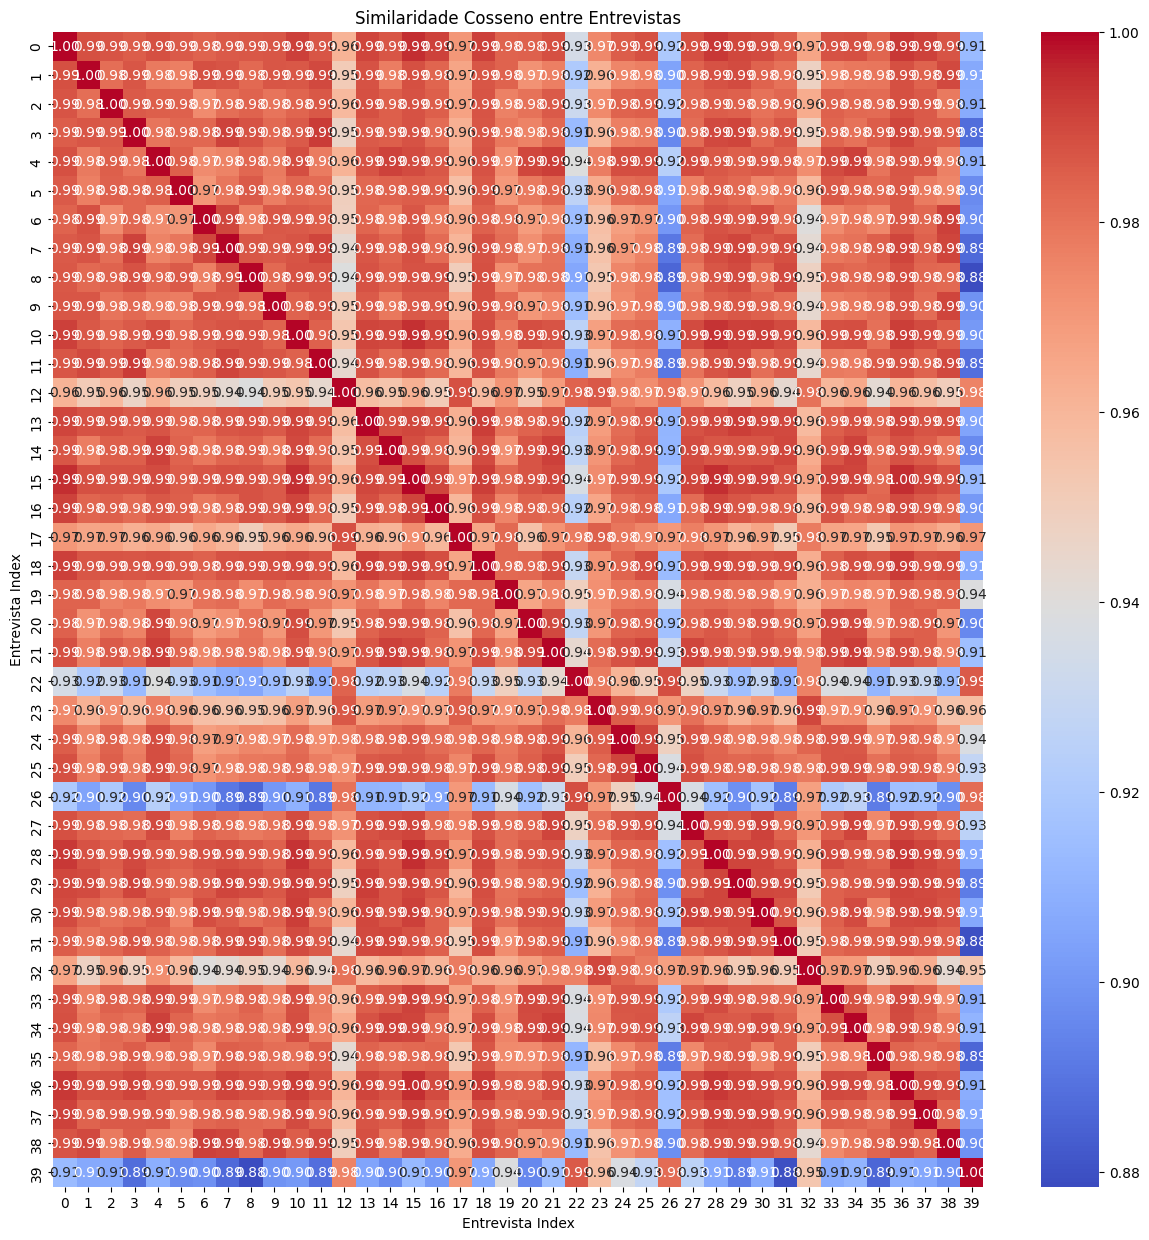

In [33]:
visualizar_similaridades(similarities, dados)

Os resultados obtidos demonstram o potencial do BERT como ferramenta de apoio na análise qualitativa, contribuindo para a redução do tempo de processamento e aumentando a consistência na interpretação dos dados.